# Get Started with Amazon SageMaker Notebook Instances and SDKs

References:
- https://docs.aws.amazon.com/sagemaker/latest/dg/gs-console.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html

Author: Gary A. Stafford

## Step 4: Download, Explore, and Transform the Training Data

## Step 4.1: Download the MNIST Dataset

In [ ]:
%%sh python3 --version

In [ ]:
%conda update --name base conda

In [2]:
import gzip
import pickle
import urllib.request

import boto3
import numpy as np
from sagemaker.inputs import TrainingInput

import sagemaker
from sagemaker import serializers

In [3]:
sagemaker.__version__

'2.16.1'

In [4]:
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
print(train_set[0].shape)

(50000, 784)


This is a 5


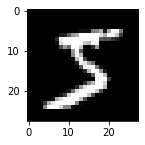

This is a 0


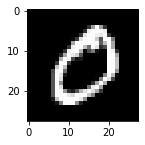

This is a 4


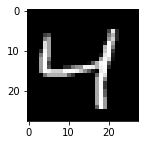

This is a 1


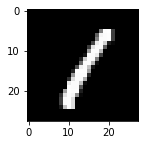

This is a 9


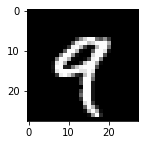

This is a 2


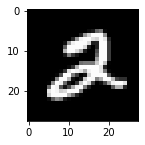

This is a 1


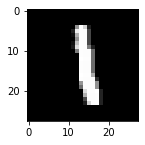

This is a 3


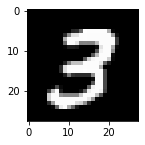

This is a 1


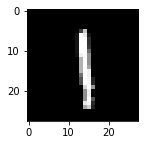

This is a 4


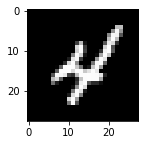

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap="gray")
    print("This is a {}".format(label))
    plt.show()

In [6]:
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# set an output path where the trained model will be saved
bucket = sagemaker.Session().default_bucket()

prefix = "sagemaker/xgboost-mnist" # Used as part of the path in the bucket where you store data

def convert_data():
    data_partitions = [("train", train_set), ("validation", valid_set), ("test", test_set)]
    for data_partition_name, data_partition in data_partitions:
        print("{}: {} {}".format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != "test":
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        
        np.savetxt("data.csv", examples, delimiter=",")
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = "s3://{}/{}".format(bucket, key)
        boto3.Session().resource("s3").Bucket(bucket).Object(key).upload_file("data.csv")
        print("Done writing to {}".format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-us-east-1-676164205626/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-us-east-1-676164205626/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-us-east-1-676164205626/sagemaker/xgboost-mnist/test/examples


## Step 5: Train a Model

In [7]:
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"multi:softmax",
        "num_class":"10",
        "num_round":"10"}

output_path = "s3://{}/{}/{}/output".format(bucket, prefix, "xgboost_model_sdk")

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# specify the repo_version depending on your preference.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", region, "1.2-1")

# construct a SageMaker estimator that calls the xgboost-container
# originally: ml.m4.xlarge
xgb_estimator = sagemaker.estimator.Estimator(image_uri=xgboost_container, 
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(),
                                          instance_count=1, 
                                          instance_type="ml.m5.2xlarge",
                                          volume_size=5, # 5 GB 
                                          output_path=output_path)

# define the data type and paths to the training and validation datasets
content_type = "text/csv"
train_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "train"), content_type=content_type)
validation_input = TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, "validation"), content_type=content_type)

In [ ]:
%%time 

# execute the XGBoost training job
xgb_estimator.fit({"train": train_input, "validation": validation_input})

2020-11-09 04:38:05 Starting - Starting the training job...
2020-11-09 04:38:07 Starting - Launching requested ML instances.........
2020-11-09 04:39:36 Starting - Preparing the instances for training...
2020-11-09 04:40:12 Downloading - Downloading input data....

## Step 6.1: Deploy the Model to SageMaker Hosting Services

In [ ]:
%%time 

serializer = serializers.CSVSerializer()
serializer.CONTENT_TYPE = "text/csv"

xgb_predictor = xgb_estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.t2.medium",
    serializer=serializer
)

In [ ]:
xgb_predictor.endpoint_name

## Step 7.1: Step 7.1: Validate a Model Deployed to SageMaker Hosting Services

In [ ]:
s3 = boto3.resource("s3")

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, "test_data")

In [ ]:
%matplotlib inline
                        
for i in range (0, 10):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap="gray")
    print("This is a {}".format(label))
    plt.show()

In [ ]:
# Should predict: 7, 2, 1, 0, 4 ,1, 4, 9, 5, 9

with open("test_data", "r") as f:
    for j in range(0,10):
        single_test = f.readline()
        result = xgb_predictor.predict(single_test)
        print(result)